<a href="https://colab.research.google.com/github/simoneCanto/Clustering_RFM/blob/main/Clustering_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Business Understanding

Um e-commerce do Reino Unido contratou os alunos da DNC para agruparem seus clientes com base nas métricas RFM (discutidas abaixo), para então definir estratégias de fidelização.

RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


O conjunto de dados fornecido contém transações ocorridas entre dezembro de 2010 e dezembro de 2011.

Seu objetivo é clusterizar os clientes com base em suas métricas de RFM.

Fonte do dataset [neste link](https://www.kaggle.com/datasets/carrie1/ecommerce-data).

# Step 2 : Data Understanding

## Setup

In [ ]:
%%capture
%pip install sidetable

In [ ]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from yellowbrick.cluster import kelbow_visualizer

from sklearn.preprocessing import RobustScaler, robust_scale, StandardScaler, scale
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [ ]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

## Dataset

In [ ]:
df = pd.read_csv('ecommerce2 (1) (2).csv', sep=';', encoding='latin1')
print(df.shape)
df.head()

(25832, 7)


,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021
1,536366,HAND WARMER UNION JACK,06/06/2021 08:28,6,1.85,17850.0,16/08/2021
2,536367,ASSORTED COLOUR BIRD ORNAMENT,06/06/2021 08:34,32,1.69,13047.0,14/05/2022
3,536368,JAM MAKING SET WITH JARS,06/06/2021 08:34,6,4.25,13047.0,14/05/2022
4,536369,BATH BUILDING BLOCK WORD,06/06/2021 08:35,3,5.95,13047.0,14/05/2022


## Data understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_pedido       25832 non-null  object 
 1   descricao       24378 non-null  object 
 2   data_pgto       25832 non-null  object 
 3   quantidade      25832 non-null  int64  
 4   preco_unitario  25832 non-null  float64
 5   id_cliente      22190 non-null  float64
 6   ultima_compra   25832 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
df[['descricao']].nunique()

descricao    3003
dtype: int64

In [ ]:
df.isna().sum()

id_pedido            0
descricao         1454
data_pgto            0
quantidade           0
preco_unitario       0
id_cliente        3642
ultima_compra        0
dtype: int64

In [ ]:
df.stb.missing()

,missing,total,percent
id_cliente,3642,25832,14.098792
descricao,1454,25832,5.628678
id_pedido,0,25832,0.000000
data_pgto,0,25832,0.000000
quantidade,0,25832,0.000000
preco_unitario,0,25832,0.000000
ultima_compra,0,25832,0.000000


In [ ]:
df.describe()

,quantidade,preco_unitario,id_cliente
count,25832.000000,25832.000000,22190.000000
mean,19.338805,21.942417,15238.498738
std,29.457949,434.435598,1733.149624
min,1.000000,-11062.060000,12346.000000
25%,2.000000,1.060000,13755.000000
50%,8.000000,2.080000,15136.000000
75%,24.000000,4.950000,16746.000000
max,151.000000,38970.000000,18287.000000


In [ ]:
df[df.preco_unitario.le(0)]

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
46,536414,NaN,06/06/2021 11:52,56,0.0,NaN,#N/D
90,536545,NaN,06/06/2021 14:32,1,0.0,NaN,#N/D
91,536546,NaN,06/06/2021 14:33,1,0.0,NaN,#N/D
92,536547,NaN,06/06/2021 14:33,1,0.0,NaN,#N/D
94,536549,NaN,06/06/2021 14:34,1,0.0,NaN,#N/D
...,...,...,...,...,...,...,...
25650,581226,missing,13/06/2022 09:56,16,0.0,NaN,#N/D
25658,581234,NaN,13/06/2022 10:33,27,0.0,NaN,#N/D
25719,581406,POLYESTER FILLER PAD 45x45cm,13/06/2022 13:58,33,0.0,NaN,#N/D
25721,581408,NaN,13/06/2022 14:06,20,0.0,NaN,#N/D


# Step 3 : Data Preparation

Missing values

In [ ]:
df_na = df.isna().sum().sort_values(ascending=False).to_frame('missing_count')
df_na['missing_pct'] = df_na.missing_count.div(df.shape[0])
df_na.style.format('{:.2%}', subset='missing_pct')

,missing_count,missing_pct
id_cliente,3642,14.10%
descricao,1454,5.63%
id_pedido,0,0.00%
data_pgto,0,0.00%
quantidade,0,0.00%
preco_unitario,0,0.00%
ultima_compra,0,0.00%


In [ ]:
df.dropna(subset=['id_cliente'], inplace=True)

In [ ]:
df.stb.missing()

,missing,total,percent
id_pedido,0,22190,0.0
descricao,0,22190,0.0
data_pgto,0,22190,0.0
quantidade,0,22190,0.0
preco_unitario,0,22190,0.0
id_cliente,0,22190,0.0
ultima_compra,0,22190,0.0


Duplicados

In [ ]:
df.duplicated().sum()

0

In [ ]:
%%timeit
pd.to_datetime(df.data_pgto)

2.23 s ± 468 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
pd.to_datetime(df.data_pgto, format='%d/%m/%Y %H:%M')

67.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
df['id_cliente'] = df.id_cliente.astype(int)
df['data_pgto'] = pd.to_datetime(df.data_pgto, format='%d/%m/%Y %H:%M')
df['ultima_compra'] = pd.to_datetime(df.ultima_compra, format='%d/%m/%Y')

In [ ]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850,2021-08-16
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850,2021-08-16
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047,2022-05-14
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047,2022-05-14
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047,2022-05-14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 25831
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_pedido       22190 non-null  object        
 1   descricao       22190 non-null  object        
 2   data_pgto       22190 non-null  datetime64[ns]
 3   quantidade      22190 non-null  int64         
 4   preco_unitario  22190 non-null  float64       
 5   id_cliente      22190 non-null  int64         
 6   ultima_compra   22190 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 1.4+ MB


Valores sem sentido

In [ ]:
df['preco_unitario'].le(0).sum()

7

In [ ]:
df = df.query('preco_unitario>0')

In [ ]:
df.describe()

,quantidade,preco_unitario,id_cliente
count,22183.000000,22183.000000,22183.000000
mean,18.380066,11.989585,15238.687869
std,28.159286,293.364478,1733.152853
min,1.000000,0.010000,12346.000000
25%,2.000000,1.250000,13755.000000
50%,8.000000,2.100000,15136.000000
75%,20.000000,4.950000,16746.000000
max,151.000000,38970.000000,18287.000000


Data visualization

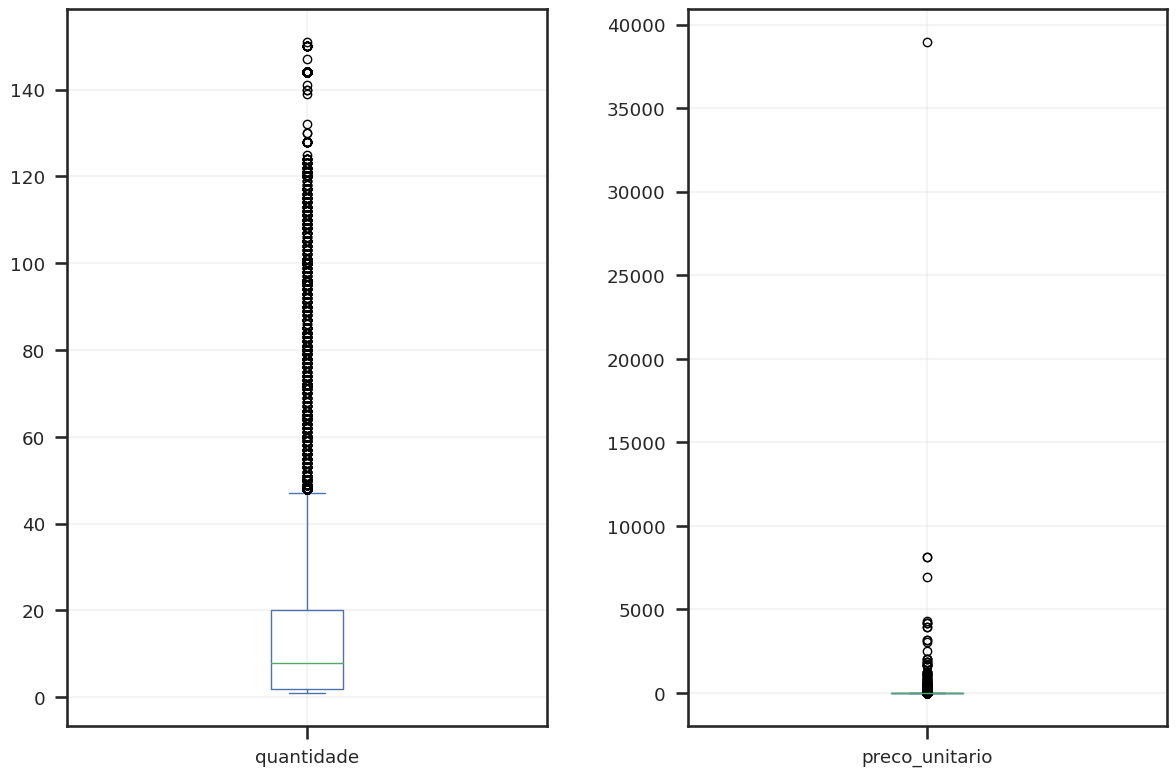

In [ ]:
df[['quantidade','preco_unitario']].plot.box(subplots=True)
plt.tight_layout(w_pad=3)
plt.show()

In [ ]:
df.query('preco_unitario > 5_000').sort_values('preco_unitario', ascending=False)

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
11509,C556445,Manual,2021-12-14 15:31:00,1,38970.00,15098,2021-12-14
8715,C551685,POSTAGE,2021-11-06 12:51:00,1,8142.75,16029,2022-05-07
8727,551697,POSTAGE,2021-11-06 13:46:00,1,8142.75,16029,2022-05-07
8729,C551699,Manual,2021-11-06 14:12:00,1,6930.00,16029,2022-05-07


In [ ]:
df = df.query('preco_unitario < 5_000')

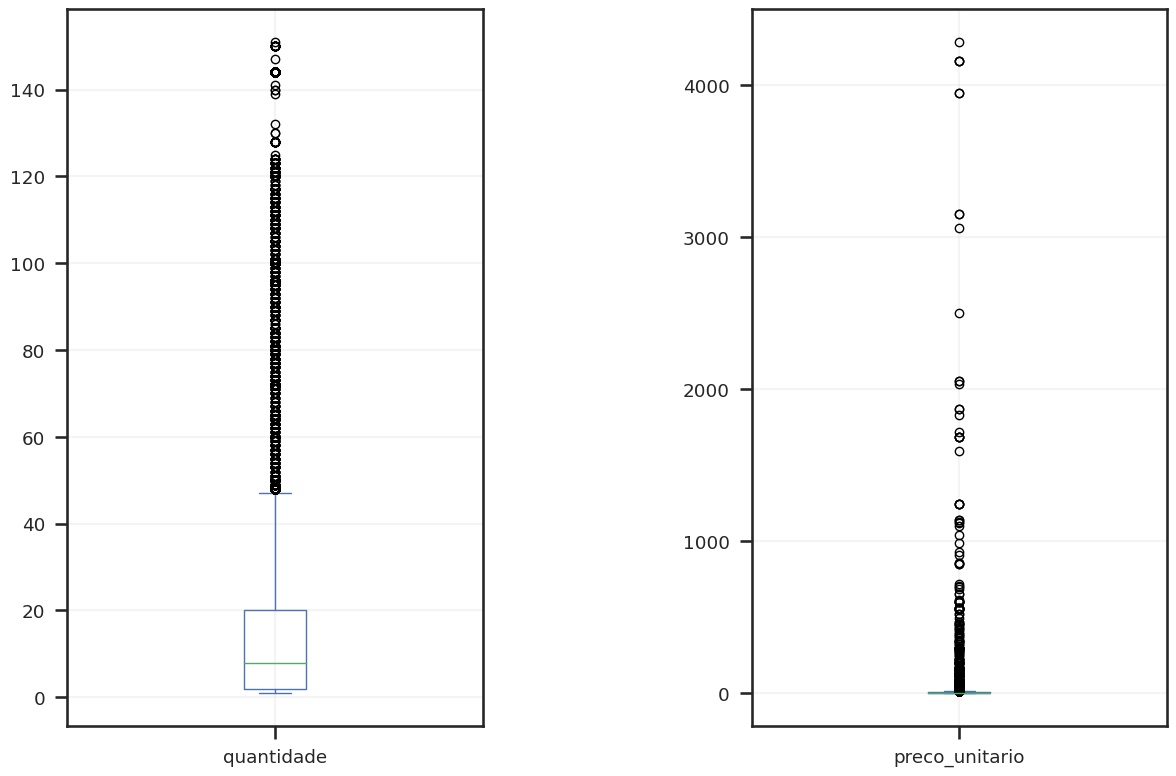

In [ ]:
df[['quantidade','preco_unitario']].plot.box(subplots=True)
plt.tight_layout(w_pad=10)
plt.show()

**Objetivo:**
- R (Recency): Tempo que o cliente realizou a última compra (Em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente


In [ ]:
df.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850,2021-08-16
1,536366,HAND WARMER UNION JACK,2021-06-06 08:28:00,6,1.85,17850,2021-08-16
2,536367,ASSORTED COLOUR BIRD ORNAMENT,2021-06-06 08:34:00,32,1.69,13047,2022-05-14
3,536368,JAM MAKING SET WITH JARS,2021-06-06 08:34:00,6,4.25,13047,2022-05-14
4,536369,BATH BUILDING BLOCK WORD,2021-06-06 08:35:00,3,5.95,13047,2022-05-14


In [ ]:
df['preco_total'] = df.preco_unitario * df.quantidade

In [ ]:
df_rfv = (
    df.groupby('id_cliente')
    .agg(
        R = ('data_pgto', lambda x: ((pd.Timestamp.today() - x.max()).days)),
        F = ('id_pedido', 'count'),
        V = ('preco_total', 'mean'),
    )
)

df_rfv

,R,F,V
id_cliente,,,
12346,911,2,14.040000
12347,587,7,23.308571
12348,661,4,82.840000
12349,604,1,15.000000
12350,895,1,25.200000
...,...,...,...
18280,863,1,23.700000
18281,766,1,5.040000
18282,593,3,15.166667


<Axes: >

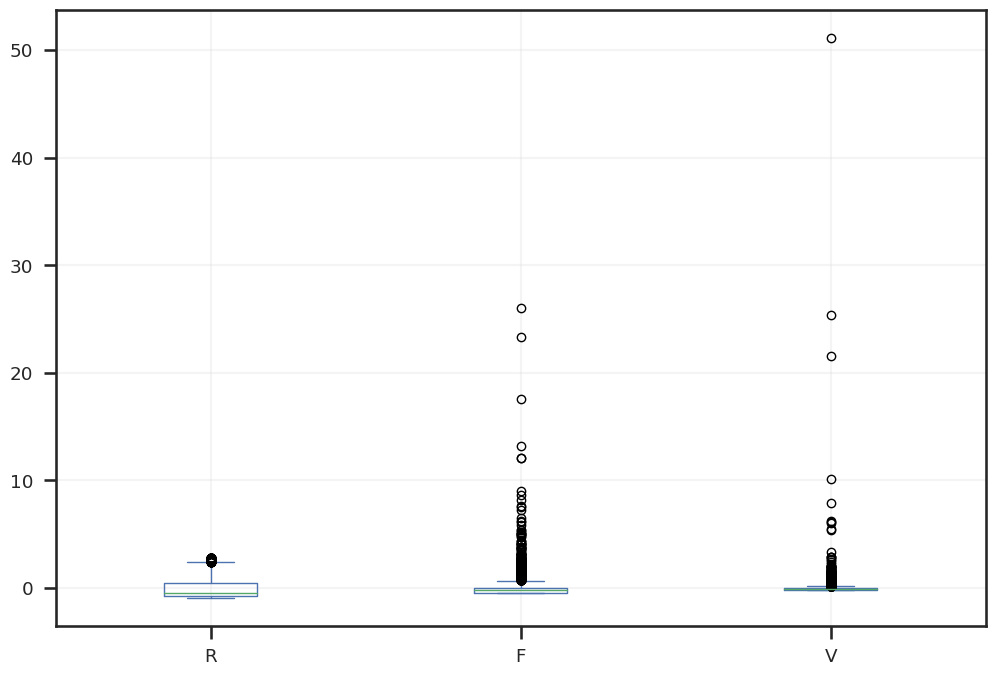

In [ ]:
# Visualizar dados padronizados
df_rfv.apply(scale).plot.box()

<Axes: >

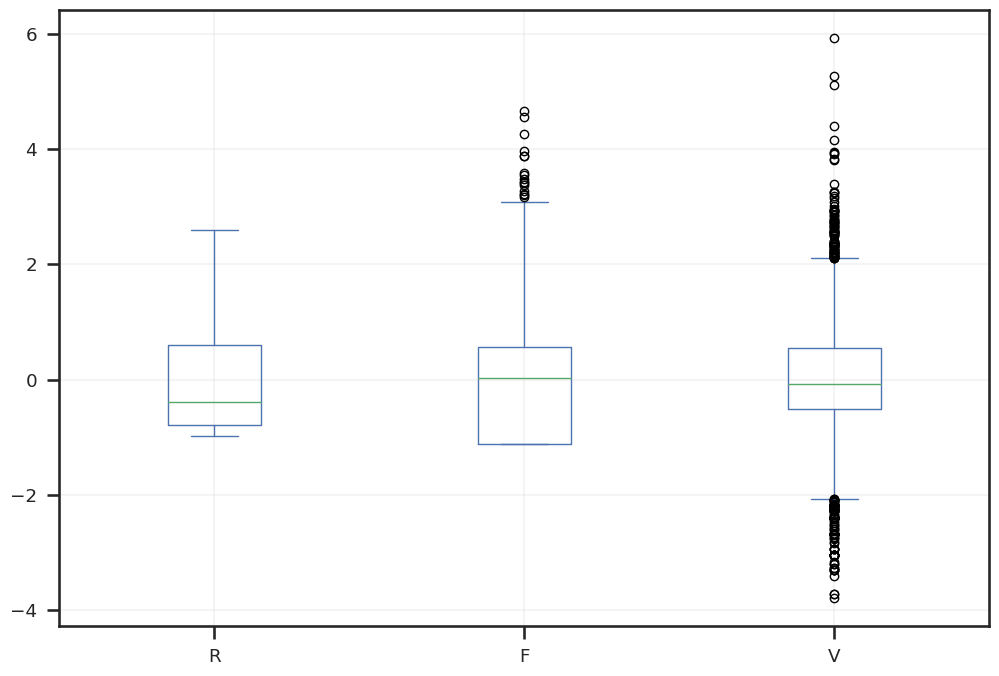

In [ ]:
# Visualizar dados transformados com log e padronizados
df_rfv.apply(np.log).apply(scale).plot.box()

In [ ]:
# Apply log-transformation and scaling
df_rfv_transformed = df_rfv.apply(np.log).apply(scale)

# Clip transformed data to max diff of 3 std
df_rfv_transformed = df_rfv_transformed.apply(lambda x: x.clip(lower=x.mean()-x.std()*3, upper=x.mean()+x.std()*3))

<Axes: >

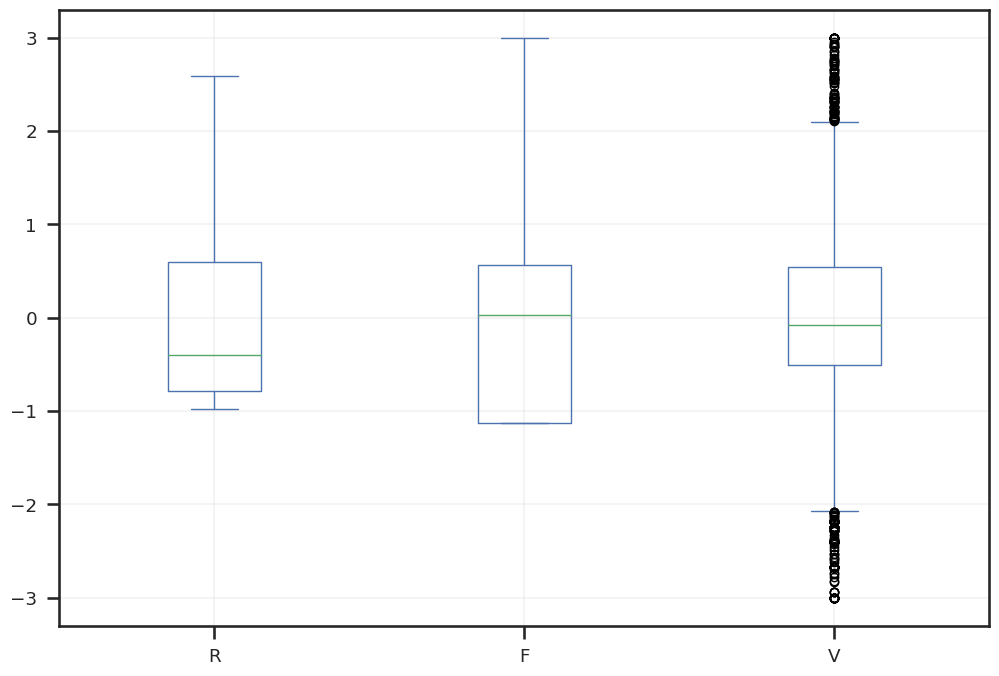

In [ ]:
df_rfv_transformed.plot.box()

In [ ]:
# Clip original data for 3D visualization
df_rfv_clip = df_rfv.apply(lambda x: x.clip(upper=x.quantile(.999)))

# Step 4-5: Modeling & Model evaluation

## K-Means

Definindo melhor K:

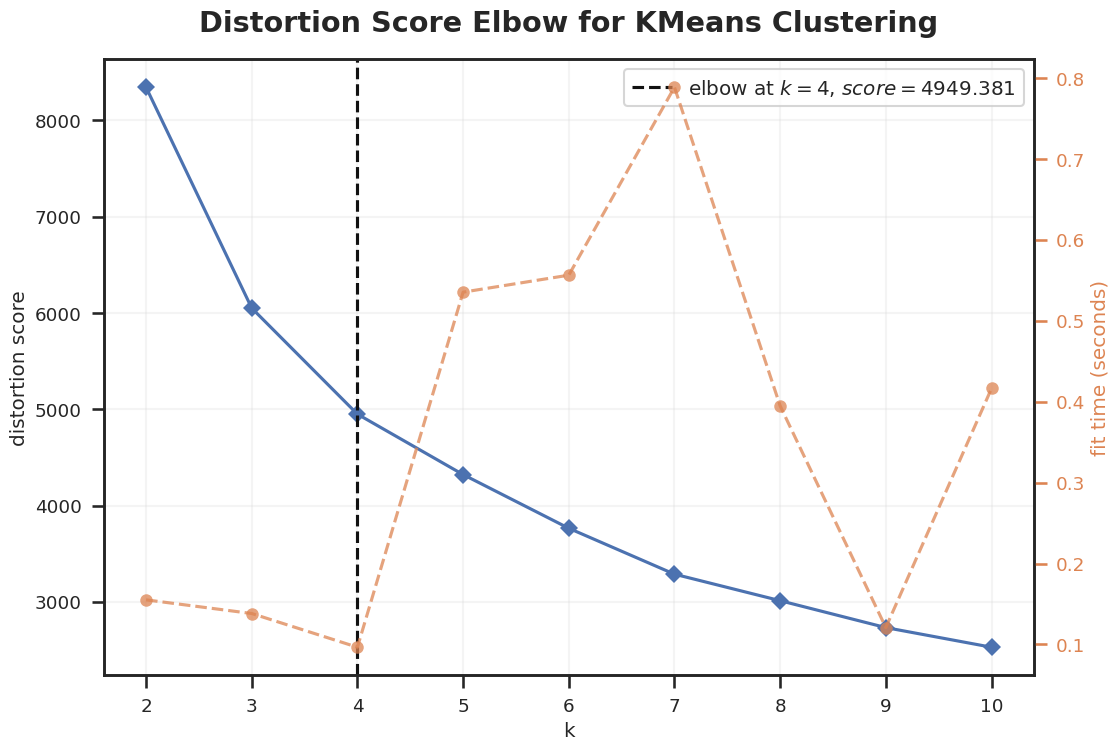

In [ ]:
kelbow_visualizer(KMeans(n_init='auto', random_state=2023), df_rfv_transformed, k=range(2,11));

In [ ]:
cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

for k in range(2,11):
  model = KMeans(n_clusters=k, n_init='auto', random_state=2023)
  labels = model.fit_predict(df_rfv_transformed)
  cluster_results_dict = {'k':k}
  cluster_results_dict['inertia'] = model.inertia_

  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(df_rfv_transformed, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient(cmap='Blues')

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8343.686704,0.325084,1.226921,2375.416764
3,6050.028268,0.318154,1.104525,2465.593473
4,4949.387386,0.321076,1.021203,2332.510598
5,4321.911117,0.285108,1.065576,2161.399531
6,3764.478856,0.293345,1.017209,2113.977842
7,3287.794512,0.298198,1.003869,2122.040716
8,3012.605064,0.295706,1.025363,2041.577848
9,2733.195754,0.310571,0.954524,2024.237303
10,2529.374865,0.293475,0.967526,1982.933384


In [ ]:
kmeans_model = KMeans(n_clusters=4, random_state=2023)
labels = kmeans_model.fit_predict(df_rfv_transformed).astype(str)

px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# pd.DataFrame(kmeans_model.cluster_centers_, columns=df_rfv_transformed.columns).T.add_prefix('Grupo_').plot.bar(subplots=True, figsize=(12,12), legend=False)
# plt.tight_layout();

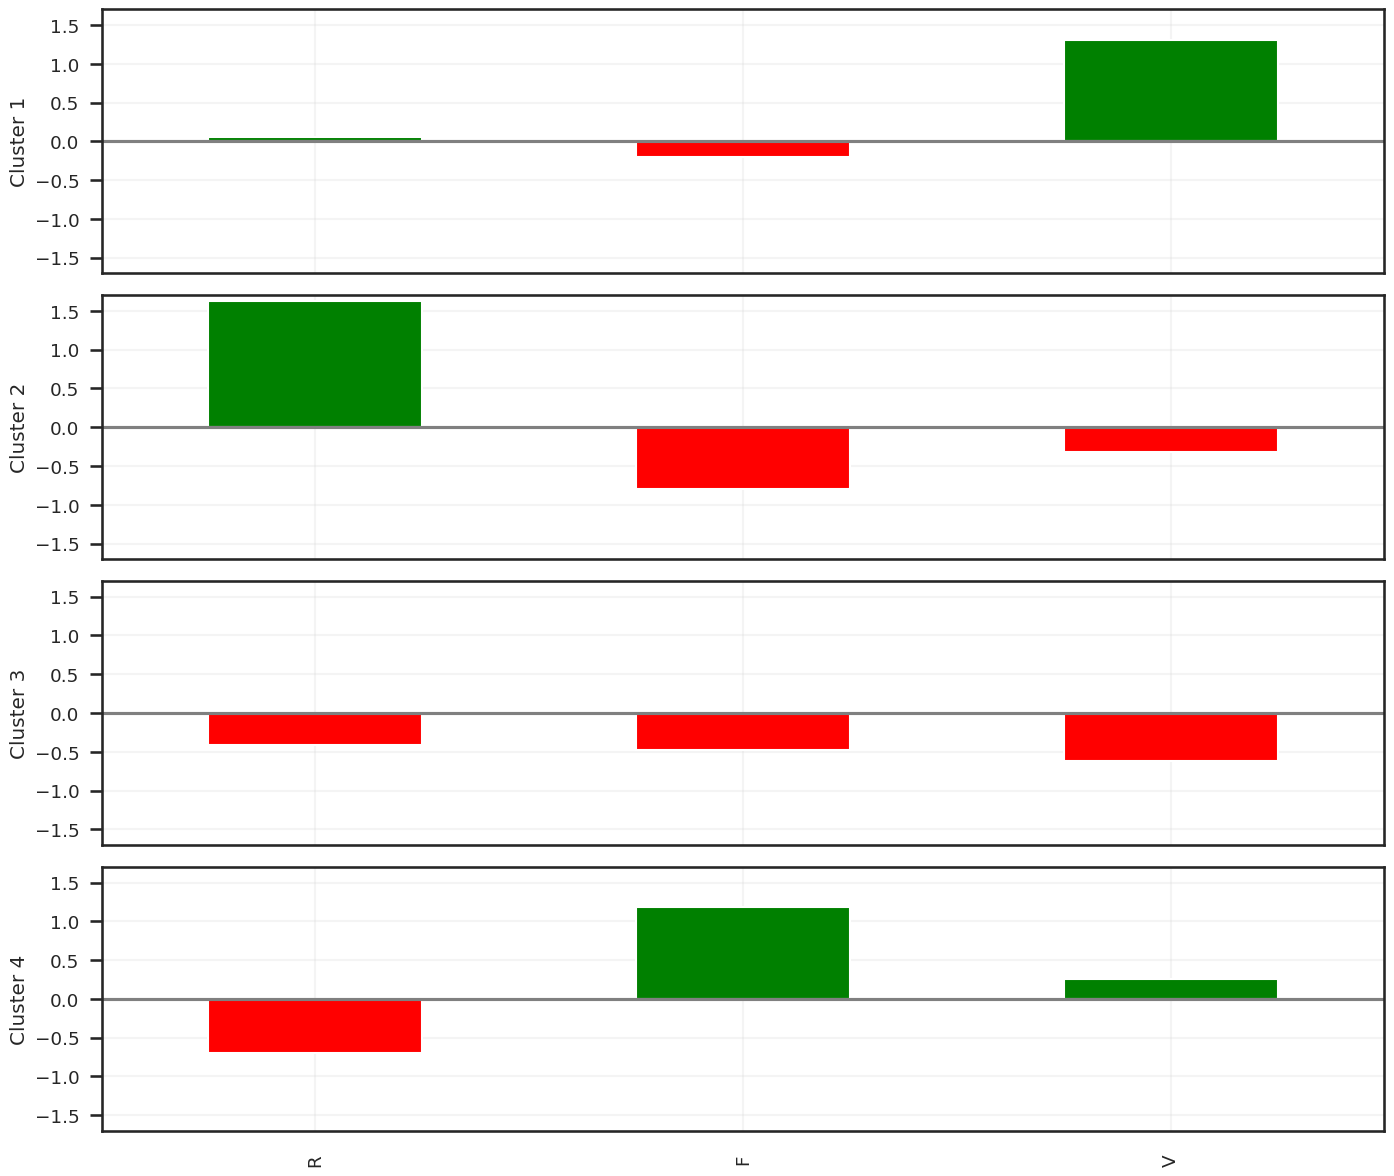

In [ ]:
# Adaptado do livro "Practical Statistics for Data Scientists"

centers = pd.DataFrame(kmeans_model.cluster_centers_, columns=df_rfv_transformed.columns)
maxPC = 1.05 * np.abs(kmeans_model.cluster_centers_).max()

fig,axes = plt.subplots(nrows=centers.shape[0], figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  # maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.tight_layout()
plt.show()

In [ ]:
df_rfv_clip.groupby(labels).agg(['mean','size'])

R                F                 V      
         mean  size       mean  size        mean  size
0  680.390135   669   2.908819   669  120.562910   669
1  841.824890   908   1.566079   908   21.475309   908
2  635.023553  1486   2.144011  1486   13.245535  1486
3  609.707951  1308  11.719419  1308   35.170862  1308

In [ ]:
df_rfv_clip.groupby(labels).mean() \
.style.background_gradient(cmap='Reds')

,R,F,V
0,680.390135,2.908819,120.562910
1,841.824890,1.566079,21.475309
2,635.023553,2.144011,13.245535
3,609.707951,11.719419,35.170862


In [ ]:
df_rfv_clip.groupby(labels).size().to_frame('cluster_size') \
.assign(cluster_size_pct = lambda x: x.cluster_size.div(df_rfv_clip.shape[0])) \
.style.format('{:.2%}', subset='cluster_size_pct')

,cluster_size,cluster_size_pct
0,669,15.31%
1,908,20.77%
2,1486,34.00%
3,1308,29.92%


## Hierarchical Clustering

In [ ]:
Z = linkage(df_rfv_transformed, method='ward')
labels = fcluster(Z, 4, criterion='maxclust')

In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## DBScan

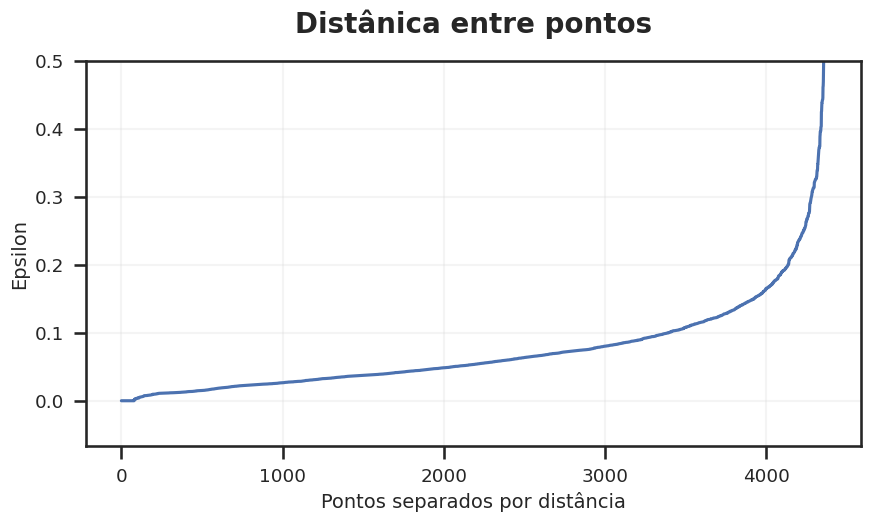

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(df_rfv_transformed)

distances, indices = nbrs.kneighbors(df_rfv_transformed)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Distânica entre pontos',fontsize=20)
plt.xlabel('Pontos separados por distância',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.ylim(top=0.5)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(df_rfv_transformed).astype(str)
pd.Series.value_counts(labels)

0     3024
1     1311
-1      32
2        4
dtype: int64

In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## Meanshift

In [ ]:
bandwidth = estimate_bandwidth(df_rfv_transformed)
bandwidth

1.6649334680925845

In [ ]:
model = MeanShift(bandwidth=1.2, n_jobs=-1)
labels = model.fit_predict(df_rfv_transformed).astype(str)

In [ ]:
np.unique(labels)

array(['0', '1', '2'], dtype='<U21')

In [ ]:
print(silhouette_score(df_rfv_transformed, labels))
print(davies_bouldin_score(df_rfv_transformed, labels))

0.28491098803644943
1.107240498920445


In [ ]:
px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

## Gaussian Mixture

In [ ]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(2,11)
covariance_types = ['full', 'tied', 'diag', 'spherical']

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, warm_start=True, covariance_type=covariance_type, random_state=2023)
    mclust.fit(df_rfv_transformed)
    results.append({
      'bic': mclust.bic(df_rfv_transformed),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
32,-2434.273393,10,full
34,-589.402201,10,diag
30,-394.558639,9,diag
28,-255.694820,9,full
26,-68.465967,8,diag


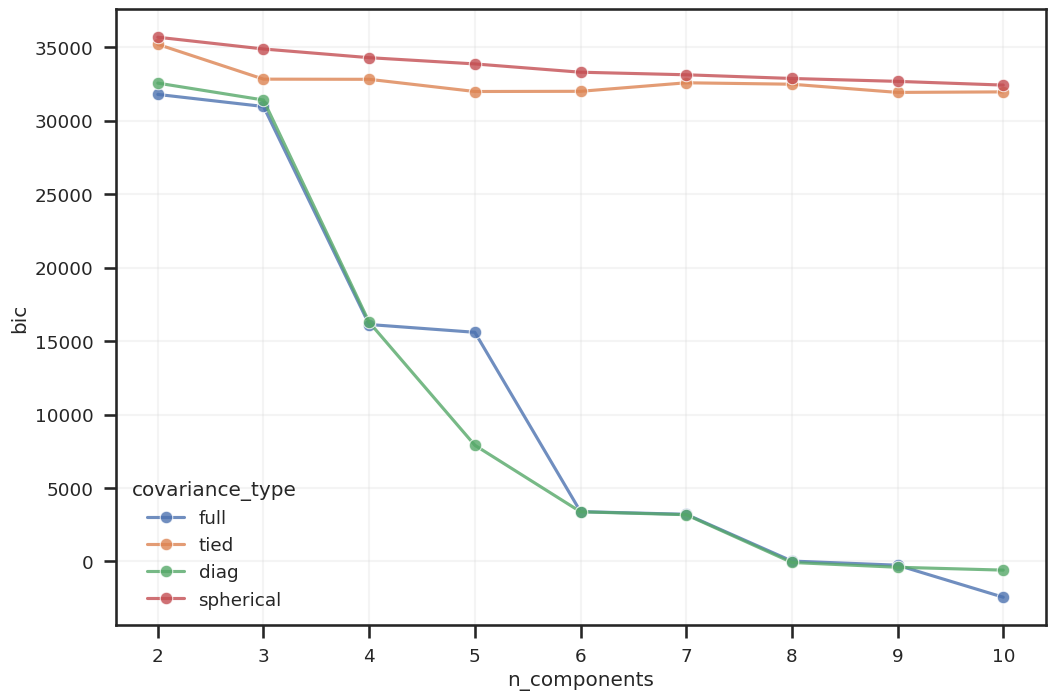

In [ ]:
# Plot
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type', marker='o', alpha=.8);

In [ ]:
mclust = GaussianMixture(n_components=6, warm_start=True, covariance_type='diag', random_state=2023)
labels = mclust.fit_predict(df_rfv_transformed).astype(str)

px.scatter_3d(data_frame=df_rfv_clip, x='R', y='F', z='V', color=labels, template='plotly_dark')

# Step 5: Interpretação dos clusters

In [ ]:
# ...